<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/NB_CNN_LC3_2020_Fuiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [0]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-06-12 22:04:25--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K  --.-KB/s    in 0.06s   

2020-06-12 22:04:25 (1.39 MB/s) - ‘ising2_label.dat’ saved [81025/81025]

--2020-06-12 22:04:28--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  5.76MB/s    in 3.2s    

2020-06-12 22:04:31 (5.76 MB/s) - ‘ising2_conf.dat’ saved [19060775/1906077

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [0]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(tf.__version__)

2.2.0


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


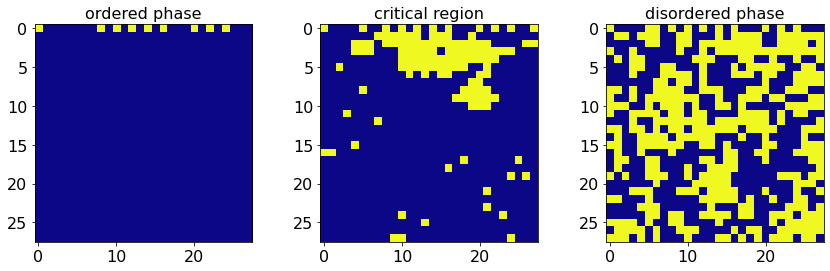

In [0]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [0]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

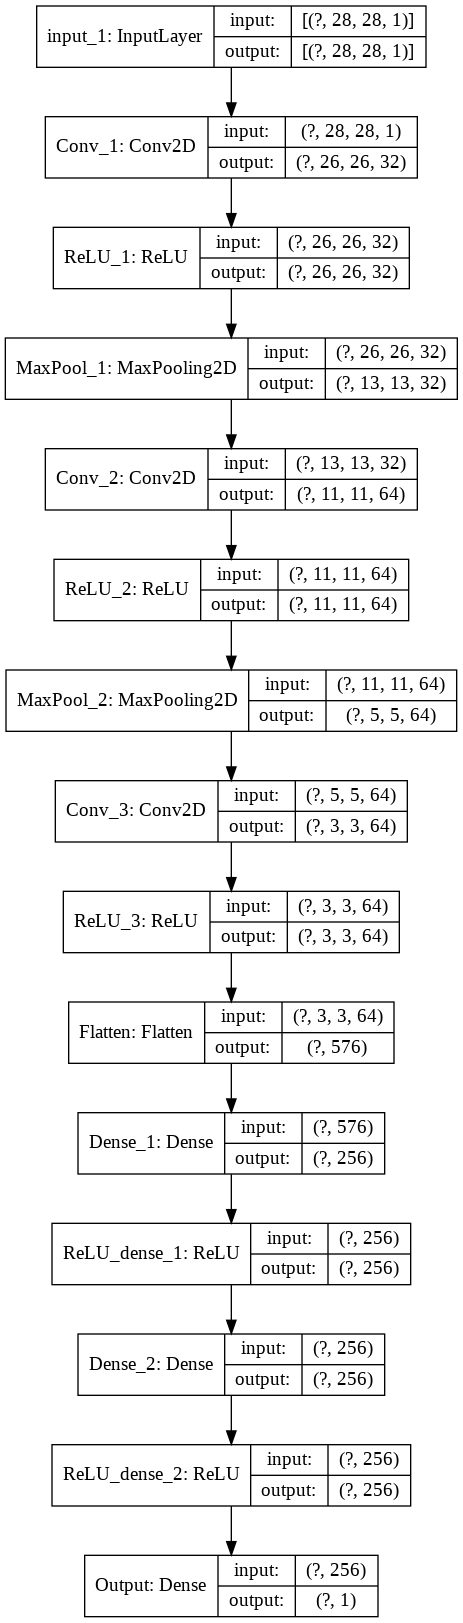

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
#x = data_augmentation(inputs)
x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

#
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
#tf.keras.layers.Conv2D(
#    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
#    dilation_rate=(1, 1), activation=None, use_bias=True,
#    kernel_initializer='glorot_uniform', bias_initializer='zeros',
#    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#    kernel_constraint=None, bias_constraint=None, **kwargs
#)
#tf.keras.layers.ReLU(
#    max_value=None, negative_slope=0, threshold=0, **kwargs
#)
#tf.keras.layers.MaxPool2D(
#    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
#)
# NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
# ridurre la size dell'immagine dopo lapplicazione del filtro

#
# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Layer denso in Keras
#tf.keras.layers.Dense(
#    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
#    **kwargs
#)
x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ model_checkpoint ]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 13ms/step - loss: 0.7855 - mean_absolute_error: 0.6432 - val_loss: 0.2647 - val_mean_absolute_error: 0.4383
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2352 - mean_absolute_error: 0.4132 - val_loss: 0.2265 - val_mean_absolute_error: 0.4004
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1824 - mean_absolute_error: 0.3567 - val_loss: 0.1540 - val_mean_absolute_error: 0.3213
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1337 - mean_absolute_error: 0.2943 - val_loss: 0.1284 - val_mean_absolute_error: 0.2818
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1231 - mean_absolute_error: 0.2766 - val_loss: 0.1566 - val_mean_absolute_error: 0.3131
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1170 - mean_absolute_error: 0.2684 - val_loss: 0.1106 - val_mean_absolute_error: 0.2559
Epoch 7/30
50/50 [=========

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0878 - mean_absolute_error: 0.2233

Test loss (MSE): 0.0878341868519783

Test MAE: 0.22330014407634735


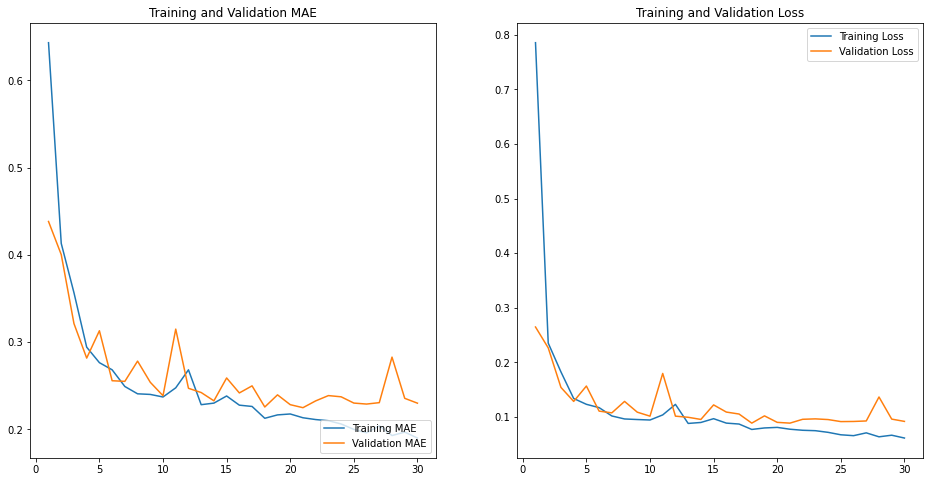

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 4.760562 VS 4.204960 Diff= 0.555602
Predicted vs True T: 2.466104 VS 2.619400 Diff= -0.153296
Predicted vs True T: 3.514873 VS 3.628900 Diff= -0.114027
Predicted vs True T: 1.816294 VS 2.008060 Diff= -0.191766
Predicted vs True T: 3.224563 VS 3.297810 Diff= -0.073247
Predicted vs True T: 2.145266 VS 2.229500 Diff= -0.084234
Predicted vs True T: 2.793779 VS 2.758380 Diff= 0.035399
Predicted vs True T: 0.701702 VS 0.346434 Diff= 0.355268
Predicted vs True T: 2.550581 VS 2.533080 Diff= 0.017501
Predicted vs True T: 4.487922 VS 4.188330 Diff= 0.299592
Sample MAE:  [0.18799314]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.981


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

#Esercizio 1: Learning rate decay

Si vuole anzitutto monitorare come mutano la mae e la mse nel caso si usi un decadimento esponenziale nel learning rate. Tale decadimento consta nel mantenere fisso il learning rate per le prime 10 epoche di ADAM (optimizer) per poi fare in modo diminuisca esponenzialmente con il numero di epoche.

Si definiscono alcune funzioni create ad hoc per i compiti da svolgere per snellire il programma.

In [0]:
#common functions definition
def plotcompare (history, comp1 = '', comp2 = ''):
  plt.close()
  mae_lrd = history.history['mean_absolute_error']
  val_mae_lrd = history.history['val_mean_absolute_error']

  loss_lrd=history.history['loss']
  val_loss_lrd=history.history['val_loss']

  #Calculating the minimum reached
  min_mae = np.amin(mae)
  min_val_mae = np.amin(val_mae)

  min_mae_lrd = np.amin(mae_lrd)
  min_val_mae_lrd = np.amin(val_mae_lrd)

  min_loss = np.amin(loss)
  min_val_loss = np.amin(val_loss)

  min_loss_lrd = np.amin(loss_lrd)
  min_val_loss_lrd = np.amin(val_loss_lrd)

  epochs_range = range(1, len(loss) + 1)

  fig, axarr = plt.subplots(nrows=2, ncols=2, figsize = ((8*2,8*2)))

  axarr[0,0].plot(epochs_range, mae, label='Training MAE, min = %.3f'%min_mae)
  axarr[0,0].plot(epochs_range, val_mae, label='Validation MAE, min = %.3f'%min_val_mae)
  axarr[0,0].legend(loc='upper right')
  axarr[0,0].set_title('Training and Validation MAE: %s'%comp1)

  axarr[0,1].plot(epochs_range, mae_lrd, label='Training MAE, min = %.3f'%min_mae_lrd)
  axarr[0,1].plot(epochs_range, val_mae_lrd, label='Validation MAE, min = %.3f'%min_val_mae_lrd)
  axarr[0,1].legend(loc='upper right')
  axarr[0,1].set_title('Training and Validation MAE: %s'%comp2)

  axarr[1,0].plot(epochs_range, loss, label='Training Loss, min = %.3f'%min_loss)
  axarr[1,0].plot(epochs_range, val_loss, label='Validation Loss, min = %.3f'%min_val_loss)
  axarr[1,0].legend(loc='upper right')
  axarr[1,0].set_title('Training and Validation Loss: %s'%comp1)

  axarr[1,1].plot(epochs_range, loss_lrd, label='Training Loss, min = %.3f'%min_loss_lrd)
  axarr[1,1].plot(epochs_range, val_loss_lrd, label='Validation Loss, min = %.3f'%min_val_loss_lrd)
  axarr[1,1].legend(loc='upper right')
  axarr[1,1].set_title('Training and Validation Loss: %s'%comp2)
  plt.show()

def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

def create_convolution(activation = 'ReLU', n_conv = 3, n_pool = 2, n_dense = 2, conv2D = 32, density = 256, augmentation = 'TRUE'):
  inputs = keras.Input(shape=(28,28,1))

  if augmentation == 'TRUE':
    data_augmentation = keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip()
    ], name='DataAugm')
    x = data_augmentation(inputs)
  elif augmentation == 'FALSE': x = inputs
  else: 
    print('Error! "augmentation" must be a boolean variable.')
    return None

  #Normal layers
  for index in range(n_conv):
    nameconv = 'Conv_'+str(index+1) 
    nameact = activation+'_'+str(index+1)
    namepool = 'MaxPool_'+str(index+1)
    
    if index == 0:
      x = keras.layers.Conv2D(conv2D, kernel_size=(3,3), name=nameconv)(x)
    else: 
      x = keras.layers.Conv2D(conv2D*2, kernel_size=(3,3), name=nameconv)(x)
    
    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

    if index < n_pool:
      x = keras.layers.MaxPool2D((2,2), name=namepool)(x)

  x = keras.layers.Flatten(name='Flatten')(x)

  #Dense layers
  for index in range(n_dense):
    namedense = 'Dense_'+str(index+1) 
    nameact = activation+'_Dense_'+str(index+1)

    x = keras.layers.Dense(density, name=namedense)(x)
    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

  outputs = keras.layers.Dense(1, name='Output')(x)
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')
 
  return outputs, model

#Accuracy function
def accuracy_func(model,X_test):
  T_c=2.26
  # CNN prediction on the complete test set
  predictions = model.predict(X_test)

  N_ord_corrette = 0 
  N_dis_corrette = 0
  N_all = 0
  for i in range(predictions.shape[0]):
    if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
      N_ord_corrette = N_ord_corrette + 1
    if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
      N_dis_corrette = N_dis_corrette + 1

  N_all = Y_test.shape[0]   

  accuracy = (N_ord_corrette+N_dis_corrette)/N_all
  print('Accuracy is: ', accuracy)  


In [0]:
outputs, model = create_convolution(augmentation='FALSE')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.5954 - mean_absolute_error: 0.5638 - val_loss: 0.2602 - val_mean_absolute_error: 0.4337 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2341 - mean_absolute_error: 0.4051 - val_loss: 0.1862 - val_mean_absolute_error: 0.3586 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1582 - mean_absolute_error: 0.3269 - val_loss: 0.1364 - val_mean_absolute_error: 0.3035 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1326 - mean_absolute_error: 0.2919 - val_loss: 0.1268 - val_mean_absolute_error: 0.2875 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1152 - mean_absolute_error: 0.2702 - val_loss: 0.1231 - val_mean_absolute_error: 0.2793 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1090 - mean_absolute_error: 0.2605 - val_loss: 0.10

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0814 - mean_absolute_error: 0.2164

Test loss (MSE): 0.08137451857328415

Test MAE: 0.2163749784231186


Si usa la funzione di plot per valutare MAE ed MSE.

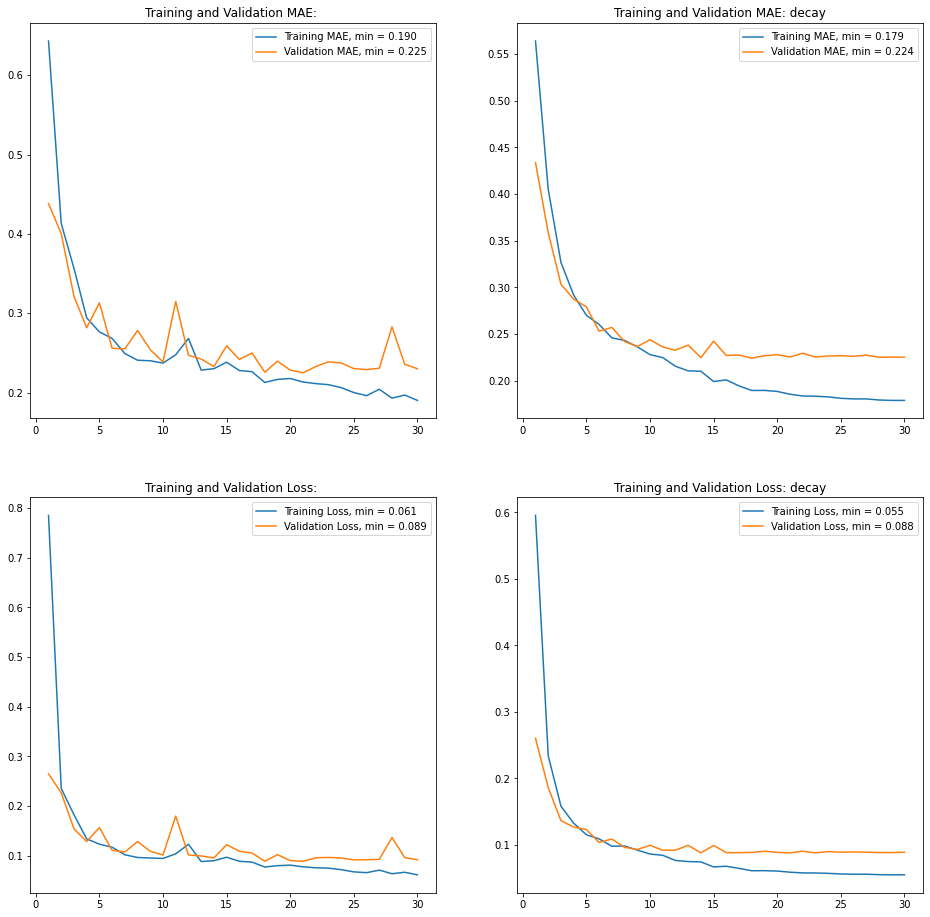

In [0]:
#Plot of the loss function 
plotcompare(history, comp2='decay')

Si nota, grazie al grafico comparativo, come il decay del learning rate ha permesso di ottenere una funzione che diventa più smooth con l'aumentare delle epoche, mantenendo pressoché invariati i risultati di mse e mae.

A causa del distacco tra validation e test set, si nota la presenza di overfitting, che si proverà in seguito a correggere.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.751160 VS 4.204960 Diff= 0.546200
Predicted vs True T: 2.629303 VS 2.619400 Diff= 0.009902
Predicted vs True T: 3.193017 VS 3.628900 Diff= -0.435883
Predicted vs True T: 1.816719 VS 2.008060 Diff= -0.191341
Predicted vs True T: 3.258842 VS 3.297810 Diff= -0.038968
Predicted vs True T: 2.389199 VS 2.229500 Diff= 0.159698
Predicted vs True T: 2.785883 VS 2.758380 Diff= 0.027503
Predicted vs True T: 0.631894 VS 0.346434 Diff= 0.285460
Predicted vs True T: 2.739100 VS 2.533080 Diff= 0.206019
Predicted vs True T: 4.213286 VS 4.188330 Diff= 0.024956
Sample MAE:  [0.19259316]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.982


Si nota un aumento di accuracy. Ciò potrebbe essere anche dovuto ad una fluttuazione statistica.

#Esercizio 2: Data augmentation

Si vuole fare ora utilizzo della data augmentation aggiungendo un layer iniziale ad essa adibito nella CNN. La data augmentation verrà operata flippando randomicamente alcuni spin. Per apprezzare il modo in cui i risultati cambiano, si esclude il learning rate decay.

In [0]:
outputs, model = create_convolution()

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.9377 - mean_absolute_error: 0.6697 - val_loss: 0.2606 - val_mean_absolute_error: 0.4355
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2333 - mean_absolute_error: 0.4101 - val_loss: 0.2145 - val_mean_absolute_error: 0.3901
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2009 - mean_absolute_error: 0.3748 - val_loss: 0.2161 - val_mean_absolute_error: 0.3846
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1778 - mean_absolute_error: 0.3494 - val_loss: 0.1715 - val_mean_absolute_error: 0.3412
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1591 - mean_absolute_error: 0.3286 - val_loss: 0.1570 - val_mean_absolute_error: 0.3183
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1545 - mean_absolute_error: 0.3203 - val_loss: 0.1645 - val_mean_absolute_error: 0.3301
Epoch 7/30
50/50 [==========

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0796 - mean_absolute_error: 0.2152

Test loss (MSE): 0.07962336391210556

Test MAE: 0.21515479683876038


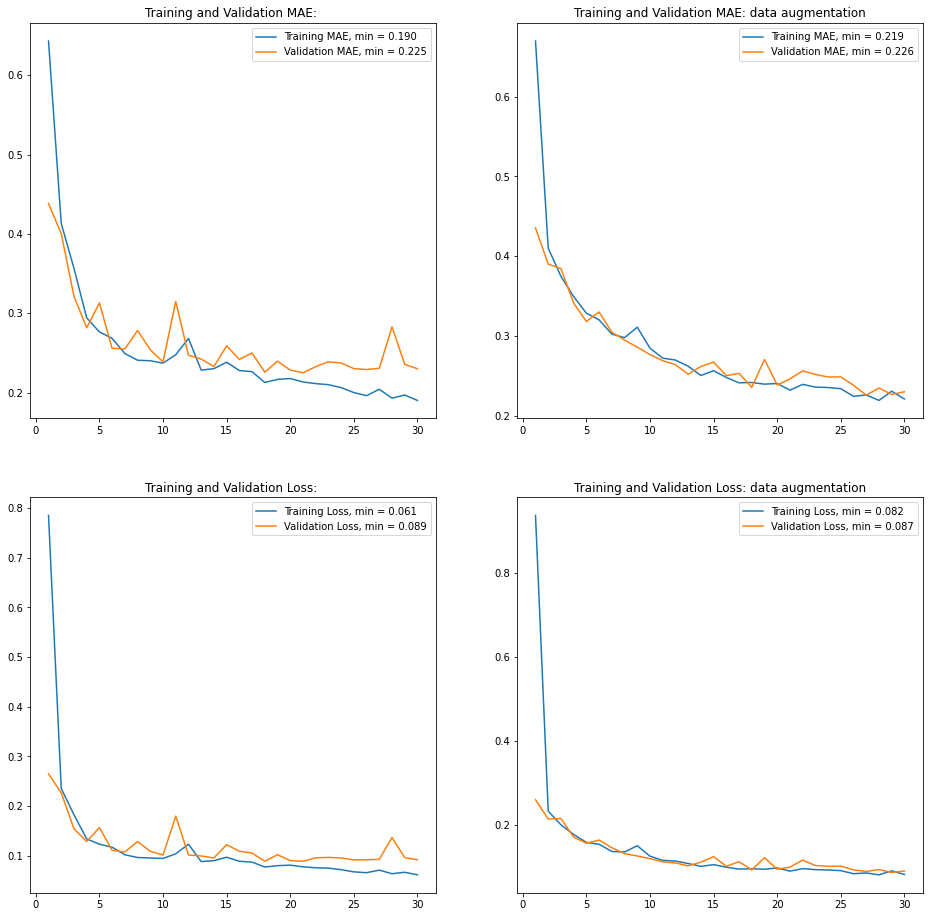

In [0]:
#Plot of the loss function 
plotcompare(history, comp2='data augmentation')

Dai grafici si nota un sensibile miglioramente dell'overfitting, anche se la smoothness può essere migliorata.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.608858 VS 4.204960 Diff= 0.403898
Predicted vs True T: 2.703856 VS 2.619400 Diff= 0.084455
Predicted vs True T: 3.507960 VS 3.628900 Diff= -0.120940
Predicted vs True T: 1.902626 VS 2.008060 Diff= -0.105434
Predicted vs True T: 3.215186 VS 3.297810 Diff= -0.082624
Predicted vs True T: 2.424536 VS 2.229500 Diff= 0.195036
Predicted vs True T: 2.678329 VS 2.758380 Diff= -0.080051
Predicted vs True T: 0.593566 VS 0.346434 Diff= 0.247132
Predicted vs True T: 2.641979 VS 2.533080 Diff= 0.108899
Predicted vs True T: 4.525114 VS 4.188330 Diff= 0.336784
Sample MAE:  [0.17652531]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9845


L'accuracy risulta praticamente identica a quella dell'algoritmo "pulito". Vi è una fluttuazione del solo $0.05\%$.

#Esercizio 2.1: Learning rate decay + data augmentation

Presa visione di come questi metodi migliorano il risultato ottenibile, si vuole provare ad applicarli simultaneamente.

In [0]:
outputs, model = create_convolution()

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.6216 - mean_absolute_error: 0.5634 - val_loss: 0.2579 - val_mean_absolute_error: 0.4315 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 10ms/step - loss: 0.2222 - mean_absolute_error: 0.4004 - val_loss: 0.1956 - val_mean_absolute_error: 0.3747 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1696 - mean_absolute_error: 0.3394 - val_loss: 0.1458 - val_mean_absolute_error: 0.3053 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1438 - mean_absolute_error: 0.3036 - val_loss: 0.1209 - val_mean_absolute_error: 0.2743 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1320 - mean_absolute_error: 0.2890 - val_loss: 0.1269 - val_mean_absolute_error: 0.2731 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1145 - mean_absolute_error: 0.2685 - val_loss: 0.1

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0750 - mean_absolute_error: 0.2068

Test loss (MSE): 0.07502176612615585

Test MAE: 0.20679229497909546


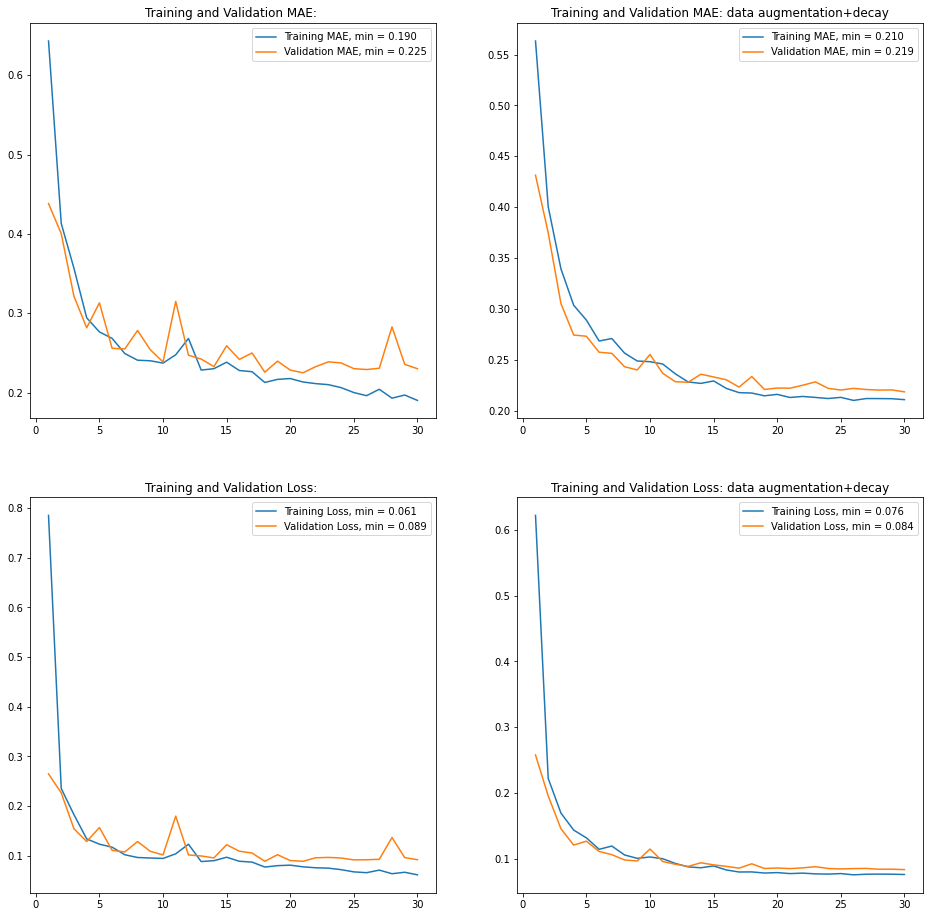

In [0]:
#Plot of the loss function 
plotcompare(history, comp2='data augmentation+decay')

Nonostante mantenga un overfitting, le funzioni risultano particolarmente smooth. D'ora in poi verranno applicati entrambi i metodi alla CNN in questione.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.616939 VS 4.204960 Diff= 0.411979
Predicted vs True T: 2.677424 VS 2.619400 Diff= 0.058024
Predicted vs True T: 3.481325 VS 3.628900 Diff= -0.147575
Predicted vs True T: 1.875126 VS 2.008060 Diff= -0.132934
Predicted vs True T: 3.376392 VS 3.297810 Diff= 0.078582
Predicted vs True T: 2.310214 VS 2.229500 Diff= 0.080714
Predicted vs True T: 2.671373 VS 2.758380 Diff= -0.087007
Predicted vs True T: 0.659917 VS 0.346434 Diff= 0.313483
Predicted vs True T: 2.616336 VS 2.533080 Diff= 0.083256
Predicted vs True T: 4.490753 VS 4.188330 Diff= 0.302423
Sample MAE:  [0.16959767]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9885


Anche quì l'accuracy sembra leggermente migliore ($+0.35\%$), ma vista l'aleatorietà dell'algoritmo la si ritiene una fluttuazione di tipo statistico.

#Esercizio 3: Funzioni di attivazione differenti



Si vogliono saggiare i risultati ottenuti cambiando funzione di attivazione ma mantenendo attivi sia learning rate decay che data augmentation. 

Si analizzano e plottano di seguito i risultati relativi alle funzioni tangente iperbolica, Leaky ReLU ed ELU.

#3.1: tanh

In [0]:
outputs, model = create_convolution(activation='tanh')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.7107 - mean_absolute_error: 0.6134 - val_loss: 0.2542 - val_mean_absolute_error: 0.4254 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2187 - mean_absolute_error: 0.3954 - val_loss: 0.2133 - val_mean_absolute_error: 0.3867 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1824 - mean_absolute_error: 0.3542 - val_loss: 0.2026 - val_mean_absolute_error: 0.3636 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1729 - mean_absolute_error: 0.3356 - val_loss: 0.1719 - val_mean_absolute_error: 0.3395 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1455 - mean_absolute_error: 0.3072 - val_loss: 0.1467 - val_mean_absolute_error: 0.3084 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1509 - mean_absolute_error: 0.3066 - val_loss: 0.13

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0871 - mean_absolute_error: 0.2242

Test loss (MSE): 0.0870734304189682

Test MAE: 0.22416767477989197


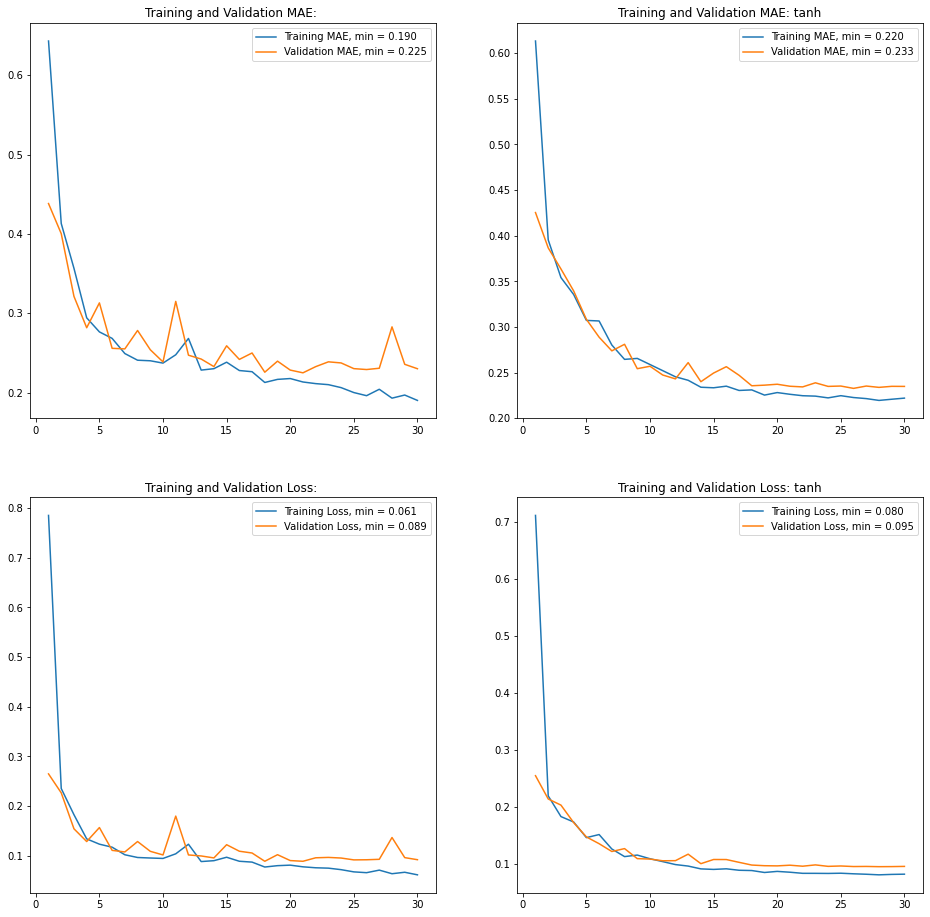

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'tanh')

L'andamento, seppure smooth dopo le 20 epoche, risulta fin troppo poco soddisfacente nelle epoche precedenti.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.639696 VS 4.204960 Diff= 0.434736
Predicted vs True T: 2.574386 VS 2.619400 Diff= -0.045014
Predicted vs True T: 3.327055 VS 3.628900 Diff= -0.301845
Predicted vs True T: 2.029969 VS 2.008060 Diff= 0.021909
Predicted vs True T: 3.480131 VS 3.297810 Diff= 0.182321
Predicted vs True T: 2.440846 VS 2.229500 Diff= 0.211346
Predicted vs True T: 2.605702 VS 2.758380 Diff= -0.152678
Predicted vs True T: 0.714247 VS 0.346434 Diff= 0.367813
Predicted vs True T: 2.600621 VS 2.533080 Diff= 0.067540
Predicted vs True T: 4.573103 VS 4.188330 Diff= 0.384773
Sample MAE:  [0.21699771]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.983


I risultati di accuracy sono i medesimi, ma visto l'andamento delle funzioni per ora si continua a preferire la ReLU.

#3.2 Leaky ReLU:

In [0]:
outputs, model = create_convolution(activation='LeakyReLU')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 10ms/step - loss: 0.7549 - mean_absolute_error: 0.6153 - val_loss: 0.2363 - val_mean_absolute_error: 0.4113 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1908 - mean_absolute_error: 0.3649 - val_loss: 0.1616 - val_mean_absolute_error: 0.3244 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1452 - mean_absolute_error: 0.3088 - val_loss: 0.1304 - val_mean_absolute_error: 0.2911 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1269 - mean_absolute_error: 0.2846 - val_loss: 0.1284 - val_mean_absolute_error: 0.2733 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1234 - mean_absolute_error: 0.2794 - val_loss: 0.1292 - val_mean_absolute_error: 0.2800 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1294 - mean_absolute_error: 0.2829 - val_loss: 0.1

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0805 - mean_absolute_error: 0.2167

Test loss (MSE): 0.08051382005214691

Test MAE: 0.21670693159103394


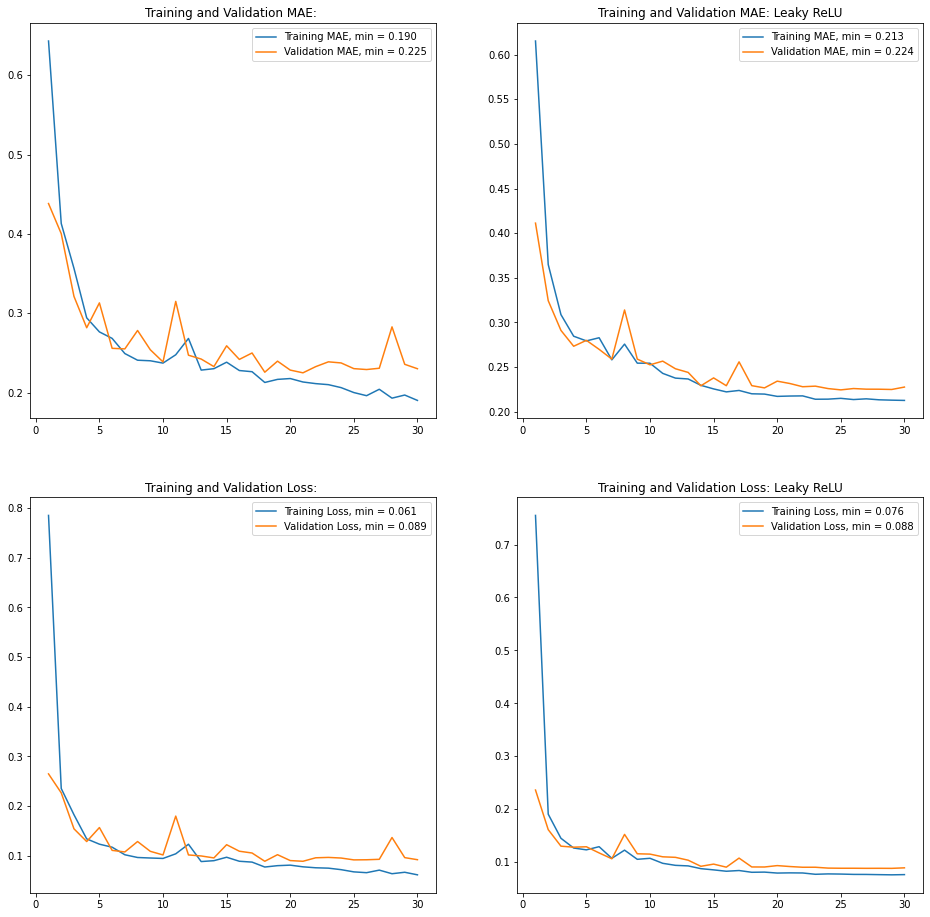

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'Leaky ReLU')

Andamento molto simile a quello di ReLU anche se con un leggero overfitting.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.726463 VS 4.204960 Diff= 0.521503
Predicted vs True T: 2.627711 VS 2.619400 Diff= 0.008311
Predicted vs True T: 3.249698 VS 3.628900 Diff= -0.379202
Predicted vs True T: 1.939278 VS 2.008060 Diff= -0.068781
Predicted vs True T: 3.432857 VS 3.297810 Diff= 0.135047
Predicted vs True T: 2.338502 VS 2.229500 Diff= 0.109002
Predicted vs True T: 2.622402 VS 2.758380 Diff= -0.135978
Predicted vs True T: 0.674909 VS 0.346434 Diff= 0.328475
Predicted vs True T: 2.666600 VS 2.533080 Diff= 0.133520
Predicted vs True T: 4.288239 VS 4.188330 Diff= 0.099908
Sample MAE:  [0.1919727]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.986


I risultati con tale funzione risultano però più alti del normale. Tenendo conto di tale dato, si decide di utilizzare nei passi successivi (hypertuning) la LeakyReLU.

#3.3 ELU:

In [0]:
outputs, model = create_convolution(activation='ELU')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.7741 - mean_absolute_error: 0.6218 - val_loss: 0.2484 - val_mean_absolute_error: 0.4139 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - mean_absolute_error: 0.3847 - val_loss: 0.1991 - val_mean_absolute_error: 0.3766 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1920 - mean_absolute_error: 0.3581 - val_loss: 0.1966 - val_mean_absolute_error: 0.3638 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1434 - mean_absolute_error: 0.3063 - val_loss: 0.1811 - val_mean_absolute_error: 0.3457 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1291 - mean_absolute_error: 0.2881 - val_loss: 0.1260 - val_mean_absolute_error: 0.2764 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1447 - mean_absolute_error: 0.3014 - val_loss: 0.1

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0891 - mean_absolute_error: 0.2287

Test loss (MSE): 0.08914027363061905

Test MAE: 0.22870323061943054


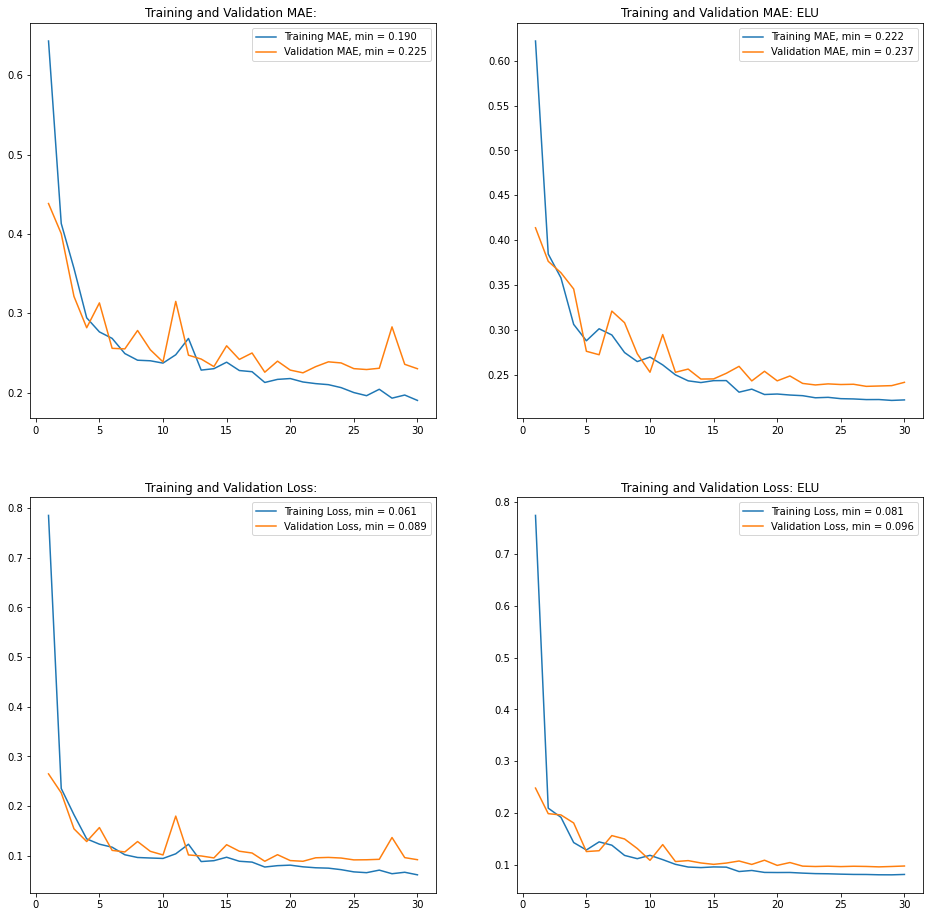

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'ELU')

Nonostante le curve rechino minore overfitting. si giunge a convergenza in un numero maggiore di epoche e l'andamento è meno smooth di quanto osservato con ReLU.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.509863 VS 4.204960 Diff= 0.304904
Predicted vs True T: 2.510389 VS 2.619400 Diff= -0.109011
Predicted vs True T: 3.258890 VS 3.628900 Diff= -0.370010
Predicted vs True T: 1.992543 VS 2.008060 Diff= -0.015517
Predicted vs True T: 3.217243 VS 3.297810 Diff= -0.080567
Predicted vs True T: 2.467657 VS 2.229500 Diff= 0.238157
Predicted vs True T: 2.763686 VS 2.758380 Diff= 0.005306
Predicted vs True T: 0.721242 VS 0.346434 Diff= 0.374808
Predicted vs True T: 2.577982 VS 2.533080 Diff= 0.044902
Predicted vs True T: 4.582053 VS 4.188330 Diff= 0.393723
Sample MAE:  [0.19369052]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9775


Il plot e un valore di accuracy leggermente inferiore a quello di riferimento continuano a far preferire l'utilizzo della sola ReLU.


#4 Keras Tuning:

Si utilizza keras tuner per provare ad applicare una semplice tecnica di tuning degli iperparametri.

Si modifica il modello in modo tale che accetti in input un parametro hp che keras tuner provvederà a settare nel modo più adeguato a seconda del range di scelta che si specificherà nella definizione del modello stesso.

Si prova dunque a tunare il numero di filtri nei convoluzionali, il numero di units nei layer densi e il learning rate di ADAM.

In [0]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=b1b17a6d02b4d1a5e480ee0d3fff3966a142c32659f83797ed78fceb3f130f02
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=28331e8c529d9daa18a67aaf7bae45a0d2323ce0f1539731778fed87605c37ad
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))
  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')
  x = data_augmentation(inputs)

  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=16, max_value=128, step=16),
      kernel_size=(3,3))(x)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  x = keras.layers.Conv2D(
    filters=hp.Int('filters', min_value=32, max_value=128, step=32),
    kernel_size=(3,3))(x)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)
  
  x = keras.layers.Conv2D(
    filters=hp.Int('filters', min_value=32, max_value=128, step=32),
    kernel_size=(3,3))(x)
  x = keras.layers.LeakyReLU()(x)

  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)

  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)

  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  
  return model


In [0]:
import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='my_new_dir')

X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

Epoch 1/10
125/125 [==============================] - 1s 10ms/step - loss: 0.7321 - mae: 0.5933 - val_loss: 0.2456 - val_mae: 0.4177
Epoch 2/10
125/125 [==============================] - 1s 9ms/step - loss: 0.2409 - mae: 0.4196 - val_loss: 0.2306 - val_mae: 0.4068
Epoch 3/10
125/125 [==============================] - 1s 9ms/step - loss: 0.2112 - mae: 0.3917 - val_loss: 0.1883 - val_mae: 0.3618
Epoch 4/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1812 - mae: 0.3562 - val_loss: 0.1529 - val_mae: 0.3203
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1522 - mae: 0.3217 - val_loss: 0.1544 - val_mae: 0.3156
Epoch 6/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1479 - mae: 0.3150 - val_loss: 0.1390 - val_mae: 0.3040
Epoch 7/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1385 - mae: 0.3032 - val_loss: 0.1239 - val_mae: 0.2842
Epoch 8/10
125/125 [==============================] - 1s 9ms/step - loss: 

Epoch 1/10
125/125 [==============================] - 1s 9ms/step - loss: 0.4238 - mae: 0.4893 - val_loss: 0.2092 - val_mae: 0.3771
Epoch 2/10
125/125 [==============================] - 1s 9ms/step - loss: 0.2511 - mae: 0.4048 - val_loss: 0.1786 - val_mae: 0.3387
Epoch 3/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1689 - mae: 0.3304 - val_loss: 0.1218 - val_mae: 0.2838
Epoch 4/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1404 - mae: 0.3008 - val_loss: 0.1813 - val_mae: 0.3502
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1314 - mae: 0.2891 - val_loss: 0.1579 - val_mae: 0.3061
Epoch 6/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1335 - mae: 0.2864 - val_loss: 0.2080 - val_mae: 0.3562
Epoch 7/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1280 - mae: 0.2802 - val_loss: 0.1178 - val_mae: 0.2740
Epoch 8/10
125/125 [==============================] - 1s 9ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 1.0278 - mae: 0.6815 - val_loss: 0.2535 - val_mae: 0.4244
Epoch 2/10
125/125 [==============================] - 1s 6ms/step - loss: 0.2501 - mae: 0.4268 - val_loss: 0.2415 - val_mae: 0.4115
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2273 - mae: 0.4079 - val_loss: 0.2121 - val_mae: 0.3865
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2040 - mae: 0.3823 - val_loss: 0.1881 - val_mae: 0.3611
Epoch 5/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1858 - mae: 0.3600 - val_loss: 0.1705 - val_mae: 0.3423
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1689 - mae: 0.3392 - val_loss: 0.1544 - val_mae: 0.3221
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1537 - mae: 0.3224 - val_loss: 0.1673 - val_mae: 0.3290
Epoch 8/10
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 1.1217 - mae: 0.7049 - val_loss: 0.2433 - val_mae: 0.4170
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2453 - mae: 0.4244 - val_loss: 0.2271 - val_mae: 0.4048
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2310 - mae: 0.4139 - val_loss: 0.2112 - val_mae: 0.3905
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2112 - mae: 0.3940 - val_loss: 0.1921 - val_mae: 0.3665
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1971 - mae: 0.3723 - val_loss: 0.1787 - val_mae: 0.3508
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1695 - mae: 0.3443 - val_loss: 0.1521 - val_mae: 0.3245
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1522 - mae: 0.3221 - val_loss: 0.1432 - val_mae: 0.3078
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4911 - mae: 0.5113 - val_loss: 0.1886 - val_mae: 0.3625
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2029 - mae: 0.3640 - val_loss: 0.1329 - val_mae: 0.2923
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1459 - mae: 0.3049 - val_loss: 0.1135 - val_mae: 0.2676
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1341 - mae: 0.2889 - val_loss: 0.1285 - val_mae: 0.2899
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1173 - mae: 0.2714 - val_loss: 0.0946 - val_mae: 0.2406
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1182 - mae: 0.2714 - val_loss: 0.1158 - val_mae: 0.2640
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1278 - mae: 0.2771 - val_loss: 0.1851 - val_mae: 0.3616
Epoch 8/10
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 10ms/step - loss: 4783.7866 - mae: 14.1291 - val_loss: 0.6477 - val_mae: 0.6132
Epoch 2/10
125/125 [==============================] - 1s 10ms/step - loss: 0.4916 - mae: 0.5455 - val_loss: 0.4794 - val_mae: 0.5416
Epoch 3/10
125/125 [==============================] - 1s 9ms/step - loss: 0.4390 - mae: 0.5177 - val_loss: 0.4205 - val_mae: 0.5093
Epoch 4/10
125/125 [==============================] - 1s 9ms/step - loss: 0.4119 - mae: 0.5021 - val_loss: 0.6738 - val_mae: 0.6374
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.3844 - mae: 0.4844 - val_loss: 0.3685 - val_mae: 0.4739
Epoch 6/10
125/125 [==============================] - 1s 9ms/step - loss: 0.4021 - mae: 0.4924 - val_loss: 0.4004 - val_mae: 0.5127
Epoch 7/10
125/125 [==============================] - 1s 10ms/step - loss: 0.3271 - mae: 0.4497 - val_loss: 0.2978 - val_mae: 0.4248
Epoch 8/10
125/125 [==============================] - 1s 9ms/step - l

Epoch 1/10
125/125 [==============================] - 1s 6ms/step - loss: 0.4396 - mae: 0.5031 - val_loss: 0.3022 - val_mae: 0.4385
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2149 - mae: 0.3812 - val_loss: 0.1757 - val_mae: 0.3374
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1727 - mae: 0.3358 - val_loss: 0.1839 - val_mae: 0.3339
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1471 - mae: 0.3071 - val_loss: 0.1182 - val_mae: 0.2784
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1280 - mae: 0.2834 - val_loss: 0.1619 - val_mae: 0.3244
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1235 - mae: 0.2786 - val_loss: 0.1083 - val_mae: 0.2611
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1298 - mae: 0.2867 - val_loss: 0.1088 - val_mae: 0.2662
Epoch 8/10
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 8ms/step - loss: 0.5112 - mae: 0.5241 - val_loss: 0.2032 - val_mae: 0.3810
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2081 - mae: 0.3786 - val_loss: 0.1653 - val_mae: 0.3424
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1713 - mae: 0.3368 - val_loss: 0.1360 - val_mae: 0.3002
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1421 - mae: 0.3051 - val_loss: 0.1247 - val_mae: 0.2924
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1693 - mae: 0.3303 - val_loss: 0.1177 - val_mae: 0.2728
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1358 - mae: 0.2961 - val_loss: 0.1479 - val_mae: 0.2970
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1398 - mae: 0.3007 - val_loss: 0.1944 - val_mae: 0.3561
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 9ms/step - loss: 0.5996 - mae: 0.5539 - val_loss: 0.2412 - val_mae: 0.4156
Epoch 2/10
125/125 [==============================] - 1s 8ms/step - loss: 0.2291 - mae: 0.4074 - val_loss: 0.2267 - val_mae: 0.3961
Epoch 3/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1797 - mae: 0.3546 - val_loss: 0.1441 - val_mae: 0.3149
Epoch 4/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1530 - mae: 0.3189 - val_loss: 0.1901 - val_mae: 0.3512
Epoch 5/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1389 - mae: 0.3023 - val_loss: 0.1732 - val_mae: 0.3358
Epoch 6/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1346 - mae: 0.2942 - val_loss: 0.1220 - val_mae: 0.2791
Epoch 7/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1224 - mae: 0.2812 - val_loss: 0.1100 - val_mae: 0.2641
Epoch 8/10
125/125 [==============================] - 1s 8ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 8ms/step - loss: 0.6508 - mae: 0.5660 - val_loss: 0.2383 - val_mae: 0.4116
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2233 - mae: 0.4016 - val_loss: 0.1872 - val_mae: 0.3662
Epoch 3/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1704 - mae: 0.3437 - val_loss: 0.1566 - val_mae: 0.3250
Epoch 4/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1491 - mae: 0.3154 - val_loss: 0.1310 - val_mae: 0.2952
Epoch 5/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1416 - mae: 0.3056 - val_loss: 0.1272 - val_mae: 0.2888
Epoch 6/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1303 - mae: 0.2924 - val_loss: 0.1269 - val_mae: 0.2805
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1335 - mae: 0.2958 - val_loss: 0.1179 - val_mae: 0.2725
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 0.

INFO:tensorflow:Oracle triggered exit


In [0]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=3)

for index,j in enumerate(models):
  test_loss, test_mae = models[index].evaluate(X_test,  Y_test, verbose=2)
  print('\nTest loss',index+1,' (MSE):', test_loss)
  print('\nTest ',index+1,' MAE:', test_mae)

63/63 - 0s - loss: 0.0916 - mae: 0.2305

Test loss 1  (MSE): 0.09156791865825653

Test  1  MAE: 0.23049628734588623
63/63 - 0s - loss: 0.0901 - mae: 0.2337

Test loss 2  (MSE): 0.09005110710859299

Test  2  MAE: 0.233669251203537
63/63 - 0s - loss: 0.0893 - mae: 0.2312

Test loss 3  (MSE): 0.08931675553321838

Test  3  MAE: 0.23121920228004456


In [0]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = models[0].fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)


Epoch 1/30
50/50 [==============================] - 1s 12ms/step - loss: 0.0854 - mae: 0.2253 - val_loss: 0.0846 - val_mae: 0.2229 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0830 - mae: 0.2225 - val_loss: 0.0840 - val_mae: 0.2221 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0810 - mae: 0.2177 - val_loss: 0.0953 - val_mae: 0.2279 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0804 - mae: 0.2164 - val_loss: 0.0856 - val_mae: 0.2176 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0781 - mae: 0.2151 - val_loss: 0.0843 - val_mae: 0.2161 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0769 - mae: 0.2137 - val_loss: 0.0806 - val_mae: 0.2156 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0775 - mae: 0.2124 - val_loss: 0.0812 - val_mae: 0.2169 - lr:

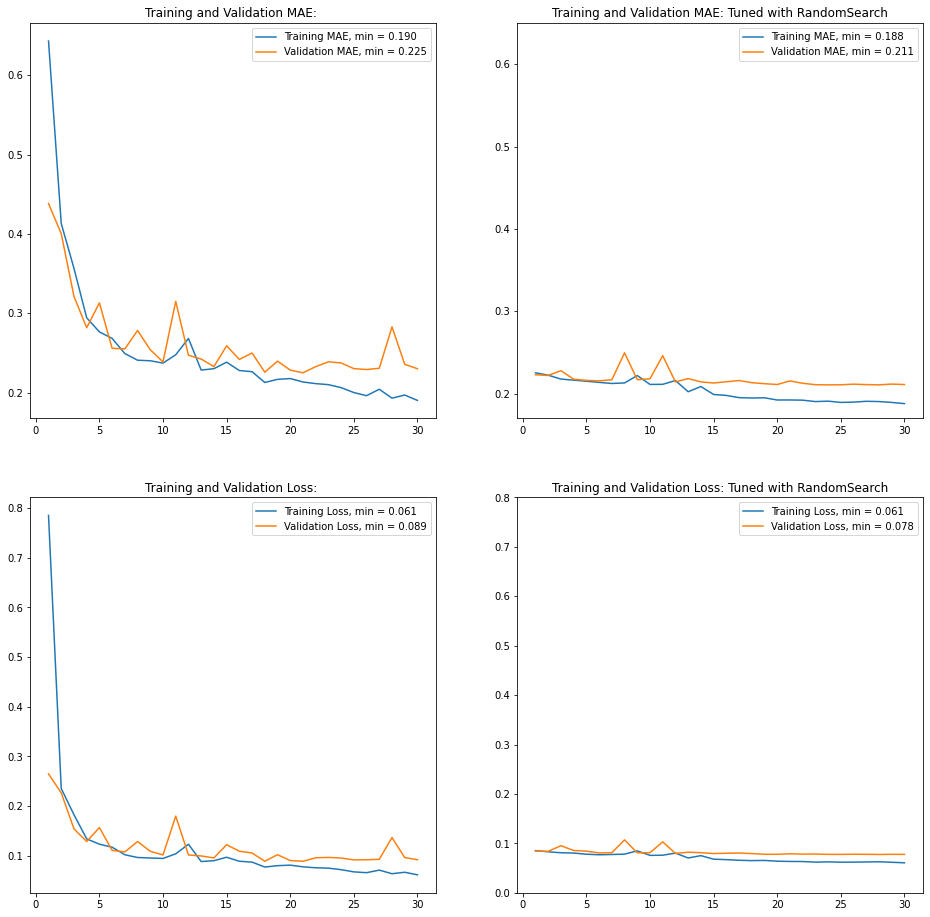

In [0]:
  plt.close()
  comp1=''
  comp2='Tuned with RandomSearch'
  mae_lrd = history.history['mae']
  val_mae_lrd = history.history['val_mae']

  loss_lrd=history.history['loss']
  val_loss_lrd=history.history['val_loss']

  #Calculating the minimum reached
  min_mae = np.amin(mae)
  min_val_mae = np.amin(val_mae)

  min_mae_lrd = np.amin(mae_lrd)
  min_val_mae_lrd = np.amin(val_mae_lrd)

  min_loss = np.amin(loss)
  min_val_loss = np.amin(val_loss)

  min_loss_lrd = np.amin(loss_lrd)
  min_val_loss_lrd = np.amin(val_loss_lrd)

  epochs_range = range(1, len(loss) + 1)

  fig, axarr = plt.subplots(nrows=2, ncols=2, figsize = ((8*2,8*2)))

  axarr[0,0].plot(epochs_range, mae, label='Training MAE, min = %.3f'%min_mae)
  axarr[0,0].plot(epochs_range, val_mae, label='Validation MAE, min = %.3f'%min_val_mae)
  axarr[0,0].legend(loc='upper right')
  axarr[0,0].set_title('Training and Validation MAE: %s'%comp1)

  axarr[0,1].plot(epochs_range, mae_lrd, label='Training MAE, min = %.3f'%min_mae_lrd)
  axarr[0,1].plot(epochs_range, val_mae_lrd, label='Validation MAE, min = %.3f'%min_val_mae_lrd)
  axarr[0,1].legend(loc='upper right')
  axarr[0,1].set_ylim((0.17,0.65))
  axarr[0,1].set_title('Training and Validation MAE: %s'%comp2)

  axarr[1,0].plot(epochs_range, loss, label='Training Loss, min = %.3f'%min_loss)
  axarr[1,0].plot(epochs_range, val_loss, label='Validation Loss, min = %.3f'%min_val_loss)
  axarr[1,0].legend(loc='upper right')
  axarr[1,0].set_title('Training and Validation Loss: %s'%comp1)

  axarr[1,1].plot(epochs_range, loss_lrd, label='Training Loss, min = %.3f'%min_loss_lrd)
  axarr[1,1].plot(epochs_range, val_loss_lrd, label='Validation Loss, min = %.3f'%min_val_loss_lrd)
  axarr[1,1].legend(loc='upper right')
  axarr[1,1].set_ylim((0.,0.8))
  axarr[1,1].set_title('Training and Validation Loss: %s'%comp2)
  plt.show()

Almeno apparentemente, sembra che grazie all'hypertuning le funzioni siano quasi costanti. Il numero di epoche per raggiungere la convergenza è quindi pressoché nullo. Nonostante ciò, si mantiene costante anche la presenza di overfitting.

In [0]:
predictions = models[1].predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.375013 VS 4.204960 Diff= 0.170053
Predicted vs True T: 2.580743 VS 2.619400 Diff= -0.038657
Predicted vs True T: 3.462853 VS 3.628900 Diff= -0.166047
Predicted vs True T: 1.977741 VS 2.008060 Diff= -0.030319
Predicted vs True T: 3.372105 VS 3.297810 Diff= 0.074295
Predicted vs True T: 2.553077 VS 2.229500 Diff= 0.323577
Predicted vs True T: 2.742958 VS 2.758380 Diff= -0.015422
Predicted vs True T: 0.604226 VS 0.346434 Diff= 0.257792
Predicted vs True T: 2.689178 VS 2.533080 Diff= 0.156097
Predicted vs True T: 4.306430 VS 4.188330 Diff= 0.118100
Sample MAE:  [0.13503595]


In [0]:
for index,J in enumerate(models):
  accuracy_func(models[index],X_test)

Accuracy is:  0.9875
Accuracy is:  0.9805
Accuracy is:  0.983


Il valore di accuracy del primo modello è pressoché identico a quello ottenuto combinando learning rate decay e data augmentation.

# 5 Batch Normalization Layers

Si vuole infine comprendere che effetto ha l'aggiunta al modello di batch normalization layers in ogni layer convoluzionale, prima della funzione di attivazione.


In [0]:
def create_batched_convolution(activation = 'ReLU', n_conv = 3, n_pool = 2, n_dense = 2, conv2D = 32, density = 256, augmentation = 'TRUE'):
  inputs = keras.Input(shape=(28,28,1))

  if augmentation == 'TRUE':
    data_augmentation = keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip()
    ], name='DataAugm')
    x = data_augmentation(inputs)
  elif augmentation == 'FALSE': x = inputs
  else: 
    print('Error! "augmentation" must be a boolean variable.')
    return None

  #Normal layers
  for index in range(n_conv):
    nameconv = 'Conv_'+str(index+1) 
    nameact = activation+'_'+str(index+1)
    namepool = 'MaxPool_'+str(index+1)
    
    if index == 0:
      x = keras.layers.Conv2D(conv2D, kernel_size=(3,3), name=nameconv)(x)
    else: 
      x = keras.layers.Conv2D(conv2D*2, kernel_size=(3,3), name=nameconv)(x)

    x = keras.layers.BatchNormalization()(x)

    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

    if index < n_pool:
      x = keras.layers.MaxPool2D((2,2), name=namepool)(x)

  x = keras.layers.Flatten(name='Flatten')(x)

  #Dense layers
  for index in range(n_dense):
    namedense = 'Dense_'+str(index+1) 
    nameact = activation+'_Dense_'+str(index+1)

    x = keras.layers.Dense(density, name=namedense)(x)
    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

  outputs = keras.layers.Dense(1, name='Output')(x)
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')
 
  return outputs, model

In [0]:
outputs, model = create_batched_convolution(activation='LeakyReLU')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 12ms/step - loss: 0.5895 - mean_absolute_error: 0.5460 - val_loss: 6.8958 - val_mean_absolute_error: 2.1492 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.2260 - mean_absolute_error: 0.3780 - val_loss: 7.5310 - val_mean_absolute_error: 2.3316 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 10ms/step - loss: 0.2306 - mean_absolute_error: 0.3834 - val_loss: 6.5055 - val_mean_absolute_error: 2.1258 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 10ms/step - loss: 0.1858 - mean_absolute_error: 0.3397 - val_loss: 5.8370 - val_mean_absolute_error: 1.9774 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 10ms/step - loss: 0.2021 - mean_absolute_error: 0.3550 - val_loss: 5.3193 - val_mean_absolute_error: 1.8446 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 10ms/step - loss: 0.2055 - mean_absolute_error: 0.3568 - val_loss:

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0884 - mean_absolute_error: 0.2298

Test loss (MSE): 0.08839937299489975

Test MAE: 0.2297648787498474


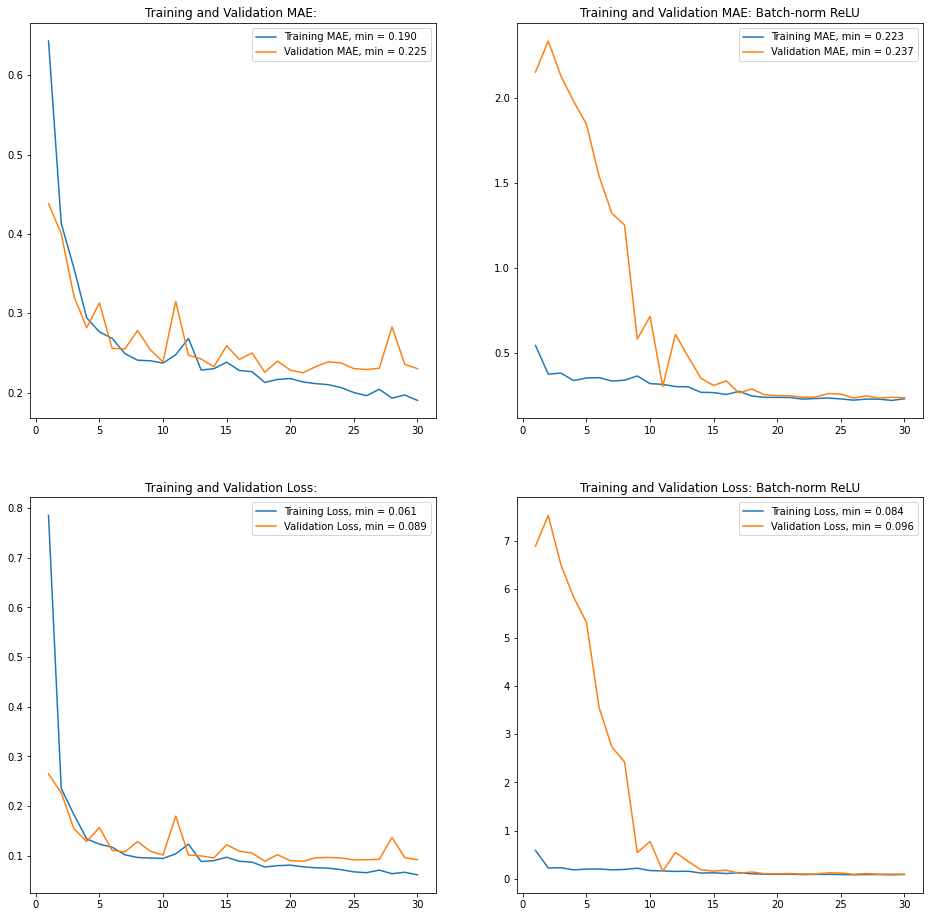

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'Batch-norm ReLU')

Nonostante il validation set parta da loss e mae molto elevati, giunge rapidamente ad un valore praticamente asintotico. La smoothness sembra migliorare, come anche migliora leggermente l'overfitting.

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 4.821270 VS 4.204960 Diff= 0.616311
Predicted vs True T: 2.588473 VS 2.619400 Diff= -0.030927
Predicted vs True T: 3.637004 VS 3.628900 Diff= 0.008104
Predicted vs True T: 1.934440 VS 2.008060 Diff= -0.073619
Predicted vs True T: 3.032817 VS 3.297810 Diff= -0.264993
Predicted vs True T: 2.333390 VS 2.229500 Diff= 0.103890
Predicted vs True T: 2.911428 VS 2.758380 Diff= 0.153048
Predicted vs True T: 0.608317 VS 0.346434 Diff= 0.261883
Predicted vs True T: 2.314872 VS 2.533080 Diff= -0.218208
Predicted vs True T: 4.552094 VS 4.188330 Diff= 0.363764
Sample MAE:  [0.20947471]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.974


Il miglioramento dell'andamento delle funzioni e dell'overfitting si ha al prezzo di una minore accuracy complessiva.